In [1]:
import pandas as pd

#file name SolarPrediction.csv
file_path = r"C:\Users\86133\LSTM\archive\SolarPrediction.csv"
df = pd.read_csv(file_path)


print(df.head())

     UNIXTime                   Data      Time  Radiation  Temperature  \
0  1475229326  9/29/2016 12:00:00 AM  23:55:26       1.21           48   
1  1475229023  9/29/2016 12:00:00 AM  23:50:23       1.21           48   
2  1475228726  9/29/2016 12:00:00 AM  23:45:26       1.23           48   
3  1475228421  9/29/2016 12:00:00 AM  23:40:21       1.21           48   
4  1475228124  9/29/2016 12:00:00 AM  23:35:24       1.17           48   

   Pressure  Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  
0     30.46        59                  177.39   5.62    06:13:00   18:13:00  
1     30.46        58                  176.78   3.37    06:13:00   18:13:00  
2     30.46        57                  158.75   3.37    06:13:00   18:13:00  
3     30.46        60                  137.71   3.37    06:13:00   18:13:00  
4     30.46        62                  104.95   5.62    06:13:00   18:13:00  


In [2]:
# transfer timestap to datetime
df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Time'])
df = df.sort_values(by='Timestamp')  # ordering by time 

C:\Users\86133\AppData\Local\Temp\ipykernel_5380\3219091102.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Data'] + ' ' + df['Time'])


In [3]:
# feature pre-processing
df['SunriseMinutes'] = pd.to_timedelta(df['TimeSunRise']).dt.total_seconds() / 60
df['SunsetMinutes'] = pd.to_timedelta(df['TimeSunSet']).dt.total_seconds() / 60
df = df.drop(columns=['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet', 'Timestamp'])

In [4]:
# select features and target
features = ['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']
target = 'Radiation'

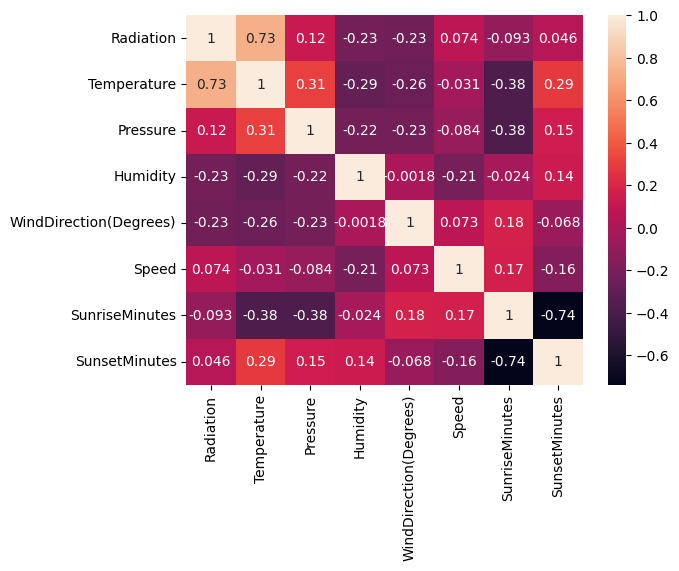

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.heatmap(df.corr(), annot=True);
#using seaborn to generate heatmap

In [6]:
# data normalization
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features + [target]])


# time series formatting
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, :-1])  
        y.append(data[i + time_step, -1])    
    return np.array(X), np.array(y)

time_step = 10
X, y = create_dataset(scaled_data, time_step)

In [7]:
# data train-split and validation
train_size = int(len(X) * 0.7)  # 70% for training
val_size = int(len(X) * 0.15)   # 15% for validation
test_size = len(X) - train_size - val_size  # 15% for testing

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print(f"Training data size: {X_train.shape}")
print(f"Validation data size: {X_val.shape}")
print(f"Testing data size: {X_test.shape}")

Training data size: (22873, 10, 5)
Validation data size: (4901, 10, 5)
Testing data size: (4902, 10, 5)


In [17]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, MultiHeadAttention, BatchNormalization, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, Reshape, LSTM, Lambda
from tensorflow.keras.layers import Dropout

# data remodeling：Conv2D
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# construct model after optimize
model = Sequential()

# Convolution layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1), padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Dropout layer
model.add(Dropout(0.5))

model.add(Reshape((-1, 128))) 

# two-way LSTM
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.5))

# Multi-Head Attention layer
query = model.output
value = model.output
key = model.output
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(query, key, value)


model.add(LSTM(units=50, return_sequences=False))

model.add(Dropout(0.5))

# output layer
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])



In [26]:

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# train model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_val_reshaped, y_val), verbose=1, callbacks=[early_stopping])


Epoch 1/100
715/715 [==============================] - 14s 20ms/step - loss: 0.0113 - mae: 0.0634 - val_loss: 0.0151 - val_mae: 0.0612
Epoch 2/100
715/715 [==============================] - 14s 19ms/step - loss: 0.0108 - mae: 0.0626 - val_loss: 0.0123 - val_mae: 0.0521
Epoch 3/100
715/715 [==============================] - 14s 20ms/step - loss: 0.0106 - mae: 0.0615 - val_loss: 0.0122 - val_mae: 0.0606
Epoch 4/100
715/715 [==============================] - 14s 20ms/step - loss: 0.0104 - mae: 0.0609 - val_loss: 0.0189 - val_mae: 0.1114
Epoch 5/100
715/715 [==============================] - 13s 19ms/step - loss: 0.0103 - mae: 0.0606 - val_loss: 0.0184 - val_mae: 0.1020
Epoch 6/100
715/715 [==============================] - 13s 19ms/step - loss: 0.0100 - mae: 0.0598 - val_loss: 0.0146 - val_mae: 0.0554
Epoch 7/100
715/715 [==============================] - 14s 20ms/step - loss: 0.0100 - mae: 0.0595 - val_loss: 0.0106 - val_mae: 0.0633
Epoch 8/100
715/715 [==============================] - 

In [27]:
import matplotlib.pyplot as plt

# extract train and validation loss 
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# extract train and validation mae
train_mae = history.history['mae']
val_mae = history.history['val_mae']

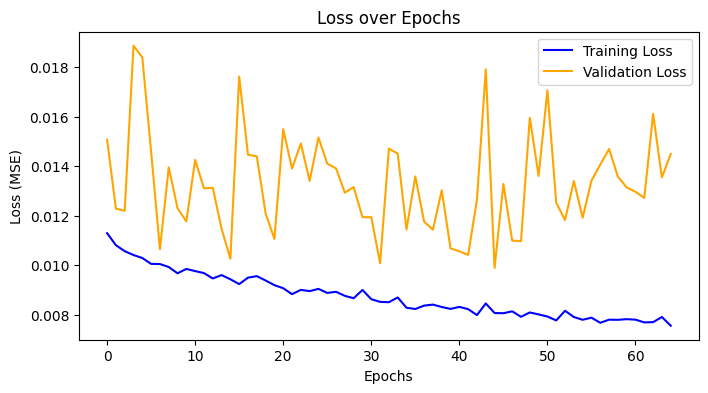

In [28]:
# generate loss figure
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

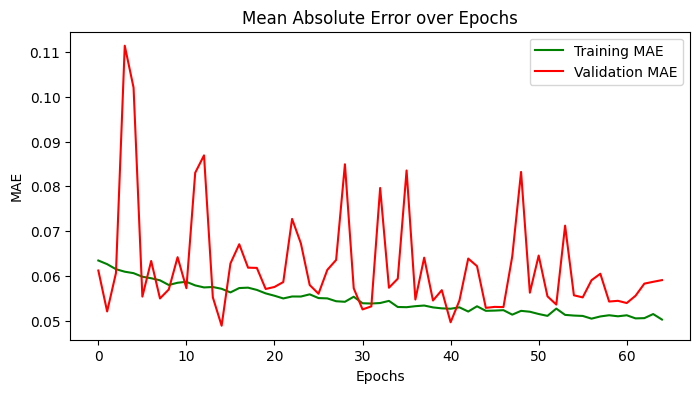

In [29]:
# generate mae figure
plt.figure(figsize=(8, 4))  
plt.plot(train_mae, label='Training MAE', color='green')
plt.plot(val_mae, label='Validation MAE', color='red')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

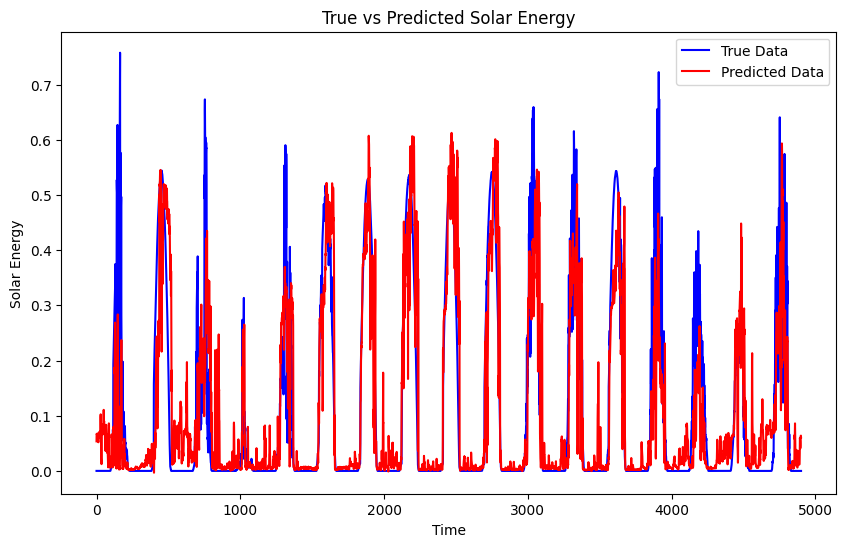

In [30]:
import matplotlib.pyplot as plt

# predicted
y_pred = model.predict(X_test_reshaped)

# compare predicted data and true data
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Data', color='blue')
plt.plot(y_pred, label='Predicted Data', color='red')
plt.title('True vs Predicted Solar Energy')
plt.xlabel('Time')
plt.ylabel('Solar Energy')
plt.legend()
plt.show()

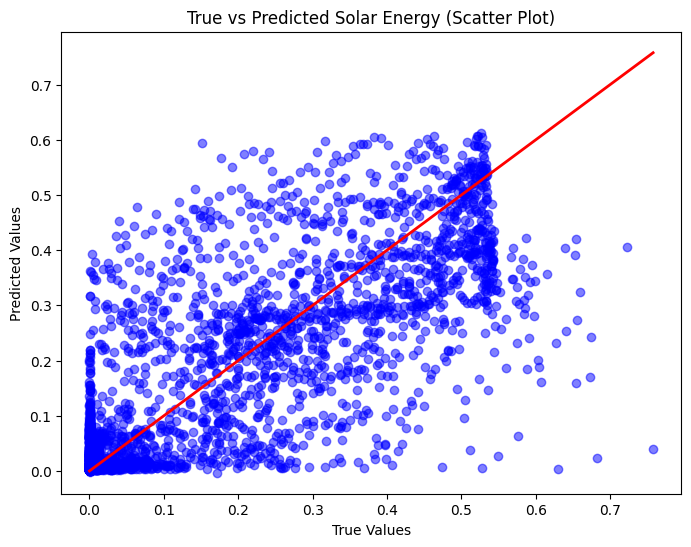

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  
plt.title('True vs Predicted Solar Energy (Scatter Plot)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()


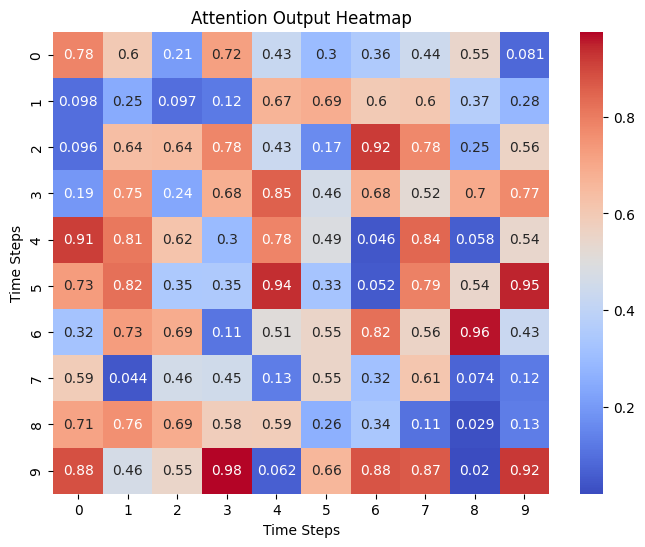

In [32]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, LSTM, MultiHeadAttention, Dropout, Reshape
from sklearn.preprocessing import MinMaxScaler

# assuming attention_output is an output from your model
attention_matrix = np.random.rand(10, 10)  # 10x10 is the matrix size

# heatmap show
plt.figure(figsize=(8, 6))
sns.heatmap(attention_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Attention Output Heatmap')
plt.xlabel('Time Steps')
plt.ylabel('Time Steps')
plt.show()


In [33]:
from sklearn.metrics import r2_score

# predicte
y_pred = model.predict(X_test_reshaped)

# calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


R² Score: 0.6838565157458707


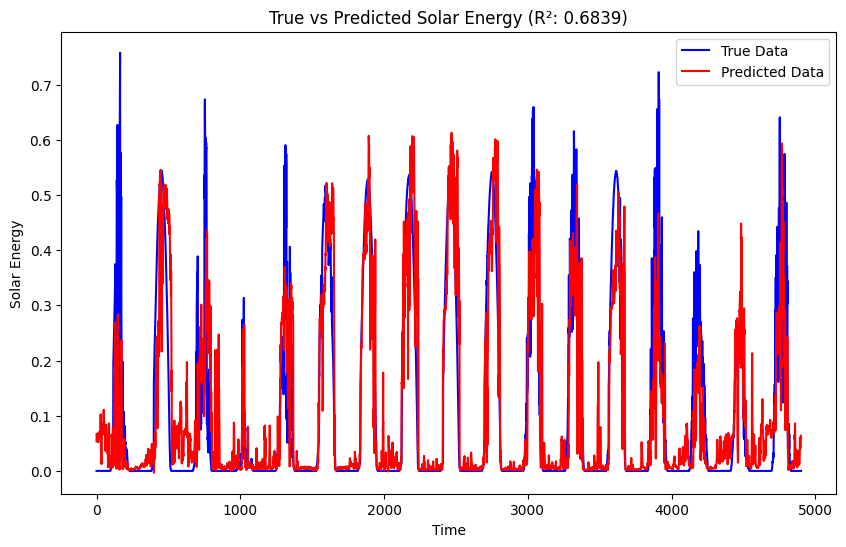

In [34]:
import matplotlib.pyplot as plt

# generate figure for comparation between true and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Data', color='blue')
plt.plot(y_pred, label='Predicted Data', color='red')
plt.title(f'True vs Predicted Solar Energy (R²: {r2:.4f})')
plt.xlabel('Time')
plt.ylabel('Solar Energy')
plt.legend()
plt.show()

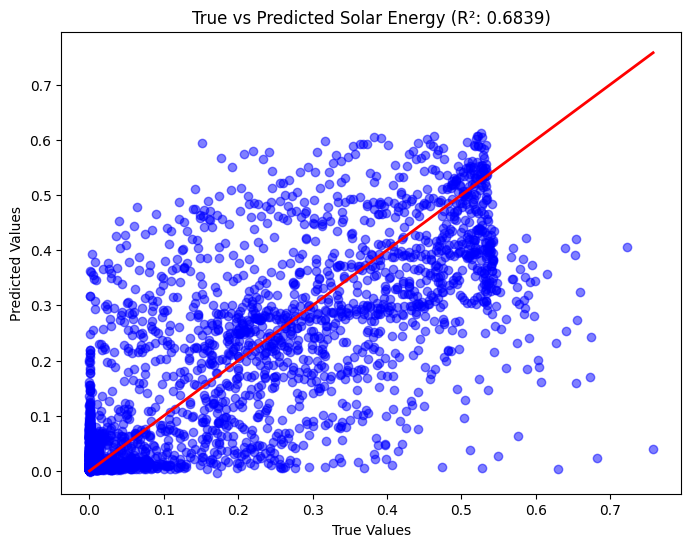

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  
plt.title(f'True vs Predicted Solar Energy (R²: {r2:.4f})')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

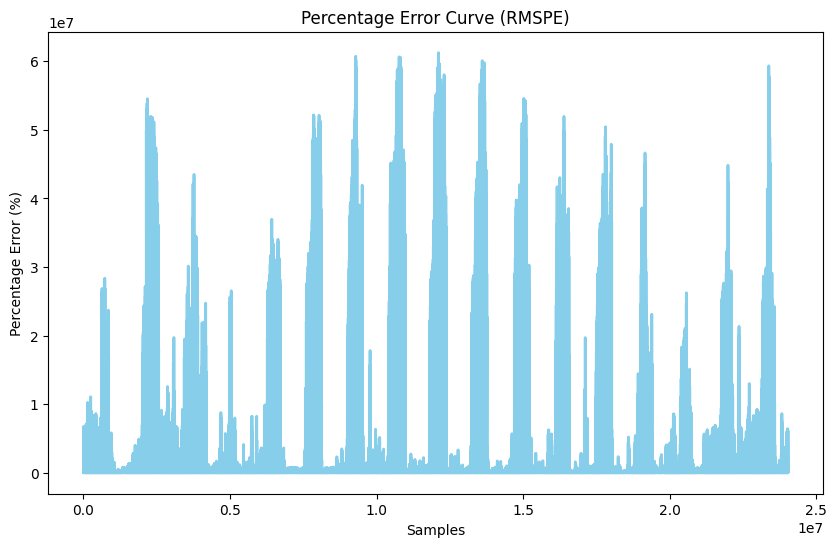

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# calculate percentage errors
percentage_errors = np.abs((y_test - y_pred) / (y_test + 1e-6)) * 100

# flatten percentage_errors 
percentage_errors = percentage_errors.flatten()

# generate percentage errors curve
plt.figure(figsize=(10, 6))
plt.plot(percentage_errors, color='skyblue', linewidth=2) 
plt.title('Percentage Error Curve (RMSPE)')
plt.xlabel('Samples')
plt.ylabel('Percentage Error (%)')
plt.show()

In [37]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer

# assume X_train is (22873, 10, 5)，it need to be reshaped to (22873, 10, 5, 1) to match the input
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)  # reshape (22873, 10, 5, 1)

#choose one sample to explain
i = 10 
X_sample = X_train_reshaped[i:i+1]  

# create LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.reshape(X_train.shape[0], -1), training_labels=y_train, mode='regression', feature_names=[f'feature_{i}' for i in range(X_train.shape[1] * X_train.shape[2])])

# modify predict_fn 
def predict_fn_adapter(data):
    data_reshaped = data.reshape(data.shape[0], X_train.shape[1], X_train.shape[2], 1)
    return model.predict(data_reshaped)

# choose one sample to explain
explanation = explainer.explain_instance(X_sample.flatten(), predict_fn_adapter)

# show result
explanation.show_in_notebook()

Explained Variance Score (EVS): 0.6841


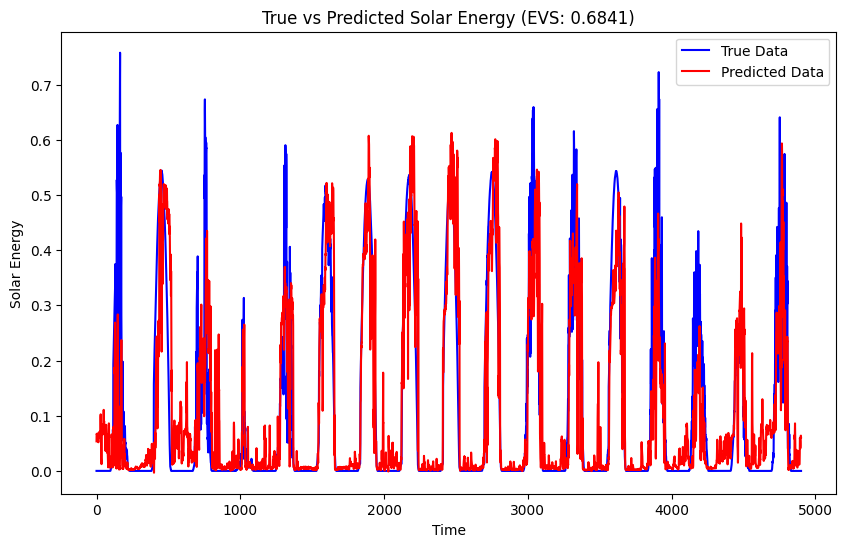

In [38]:
from sklearn.metrics import explained_variance_score

# calculate EVS score
evs = explained_variance_score(y_test, y_pred)

# print EVS score
print(f'Explained Variance Score (EVS): {evs:.4f}')


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Data', color='blue')
plt.plot(y_pred, label='Predicted Data', color='red')
plt.title(f'True vs Predicted Solar Energy (EVS: {evs:.4f})')
plt.xlabel('Time')
plt.ylabel('Solar Energy')
plt.legend()
plt.show()


Explained Variance Score (EVS): 0.6841


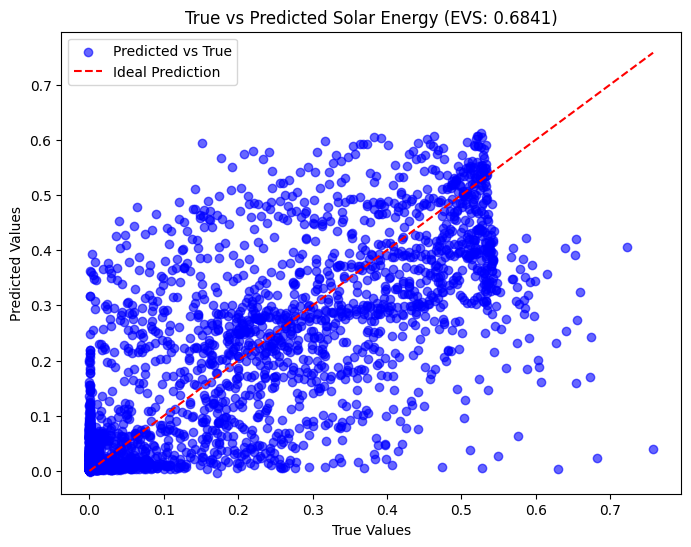

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

# calculate EVS
evs = explained_variance_score(y_test, y_pred)

# print EVS score
print(f'Explained Variance Score (EVS): {evs:.4f}')


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'True vs Predicted Solar Energy (EVS: {evs:.4f})')
plt.legend()
plt.show()

In [41]:
import numpy as np

# calculate RMSPE
def calculate_rmspe(y_true, y_pred):
    # find index of non-0 value
    non_zero_indices = y_true != 0
    # calculate RMSPE
    return np.sqrt(np.mean(((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])**2)) / 100

# calculate testing RMSPE
rmspe = calculate_rmspe(y_test, y_pred)
print(f"Root Mean Square Percentage Error (RMSPE): {rmspe:.2f}%")

Root Mean Square Percentage Error (RMSPE): 22.07%


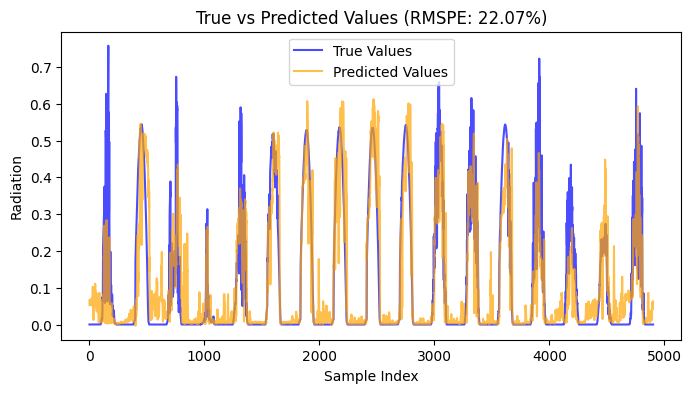

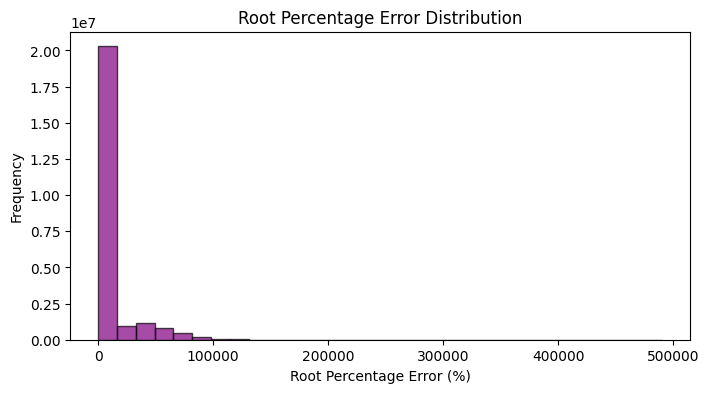

In [42]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 4))
plt.plot(y_test, label='True Values', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Values', color='orange', alpha=0.7)
plt.title(f'True vs Predicted Values (RMSPE: {rmspe:.2f}%)')
plt.xlabel('Sample Index')
plt.ylabel('Radiation')
plt.legend()
plt.show()


percentage_squared_errors = (((y_test - y_pred) / np.where(y_test == 0, np.nan, y_test))**2) * 100
percentage_squared_errors = percentage_squared_errors[~np.isnan(percentage_squared_errors)]  # 去掉 NaN

plt.figure(figsize=(8, 4))
plt.hist(np.sqrt(percentage_squared_errors), bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title('Root Percentage Error Distribution')
plt.xlabel('Root Percentage Error (%)')
plt.ylabel('Frequency')
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
import numpy as np

# define RMSE calculation method
def calculate_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse


In [44]:
# predict by using testing sample
y_pred = model.predict(X_test_reshaped)

# rescale
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_pred), axis=1))[:, -1]

# calculate RMSE
rmse = calculate_rmse(y_test_rescaled, y_pred_rescaled)
print(f"RMSE: {rmse}")


RMSE: 155.18991974029333


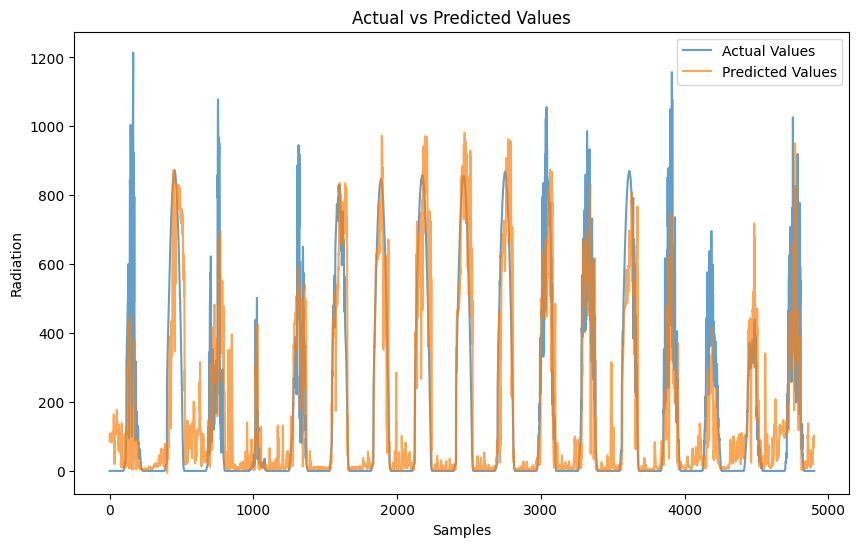

RMSE: 155.18991974029333


In [45]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Values', alpha=0.7)
plt.plot(y_pred_rescaled, label='Predicted Values', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Radiation')
plt.legend()
plt.show()

# print RMSE value
print(f"RMSE: {rmse}")


In [51]:
import numpy as np

# tolerance
tolerance = 0.2

# calculate accuracy between tolerance
accuracy = np.mean(np.abs(y_true - y_pred) <= tolerance)
print(f"Accuracy within tolerance {tolerance}: {accuracy * 100:.2f}%")


Accuracy within tolerance 0.2: 80.00%


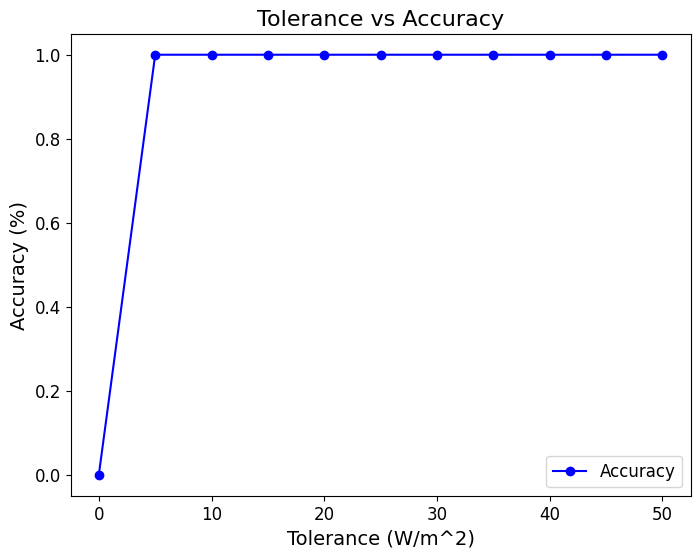

In [53]:
import numpy as np
import matplotlib.pyplot as plt



# define different tolerance
tolerances = np.arange(0, 51, 5)  

# calculate accuracy between different tolerance
accuracies = []
for tolerance in tolerances:
    absolute_error = np.abs(y_true - y_pred)
    accuracy = np.mean(absolute_error <= tolerance)  
    accuracies.append(accuracy)

# generate Tolerance vs Accuracy figure
plt.figure(figsize=(8, 6))
plt.plot(tolerances, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Tolerance vs Accuracy', fontsize=16)
plt.xlabel('Tolerance (W/m^2)', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()
